<a href="https://colab.research.google.com/github/Jana-Alrzoog/2025_GP_28/blob/main/masar-sim/notebooks/masar_base_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to programmatically generate a standardized baseline demand curve. This curve mathematically models the typical passenger flow on a nominal weekday, characterized by predictable morning and evening commute peaks. This process establishes a foundational, normalized pattern that serves as a default template for any given day.

In [ ]:
# ============================================================
#  Masar Base Demand Generation Notebook
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml, json

In [ ]:
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd 2025_GP_28


Cloning into '2025_GP_28'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 436 (delta 127), reused 303 (delta 67), pack-reused 1 (from 1)
Receiving objects: 100% (436/436), 1.67 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/2025_GP_28/2025_GP_28


In [ ]:
# ============================================================
# 1. Load Configuration Files
# ============================================================

seed_path = "/content/2025_GP_28/masar-sim/data/seeds"
config_path = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"

with open(config_path) as f:
    config = yaml.safe_load(f)

with open(f"{seed_path}/stations.json") as f:
    stations = json.load(f)

print(f"Loaded {len(stations)} stations ✅")

Loaded 6 stations ✅


This code defines the mathematical model for demand peaks. A gaussian ( or bell curve ) function is employed as it provides a smooth and realistic model for the gradual rise and fall of passenger volume during peak commute hours. A second function, base_demand_curve, combines multiple Gaussian curves to represent both the morning and evening peaks.

In [ ]:
# ============================================================
# 2. Gaussian-based Base Demand Function
# ============================================================

def gaussian(x, mu, sigma_h):
    """Return Gaussian value for minute-of-day"""
    sigma = sigma_h * 60.0  # convert hours → minutes
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def base_demand_curve(minute_of_day, config):
    """Create combined morning + evening peaks + baseline"""
    peaks = config["peaks"]
    base = 0.05  # constant small baseline
    demand = base
    for p in peaks:
        mu = p["hour"] * 60
        sigma_h = p["sigma_hours"]
        demand += gaussian(minute_of_day, mu, sigma_h)
    return demand

This function, generate_base_day, constructs the full 24-hour demand profile for a single station. It applies the mathematical model from Section 2 for each minute of the day. Crucially, it then normalizes the resulting curve by scaling its maximum value to 1.0, ensuring a consistent and comparable standard across all stations.

In [ ]:
# ============================================================
# 3. Generate Daily Curve (One Station Example)
# ============================================================

def generate_base_day(station_id, config):
    """Generate normalized base demand (0..~2.5) for one station"""
    start = datetime(2025, 9, 23, 6, 0)

    end   = datetime(2025, 9, 24, 0, 0)
    times = pd.date_range(start, end, freq="1min")

    minutes = [t.hour * 60 + t.minute for t in times]
    base_values = [base_demand_curve(m, config) for m in minutes]

    df = pd.DataFrame({
        "timestamp": times,
        "station_id": station_id,
        "base_demand": base_values
    })

    # Normalize so max = 1.0
    df["base_demand_norm"] = df["base_demand"] / df["base_demand"].max()
    return df

Here shows a visual validation step. It runs the function from Section 3 for a single sample station and plots the resulting curve using matplotlib. This visual inspection allows for confirmation that the curve exhibits the expected bimodal (two-peak) distribution corresponding to morning and evening commutes.

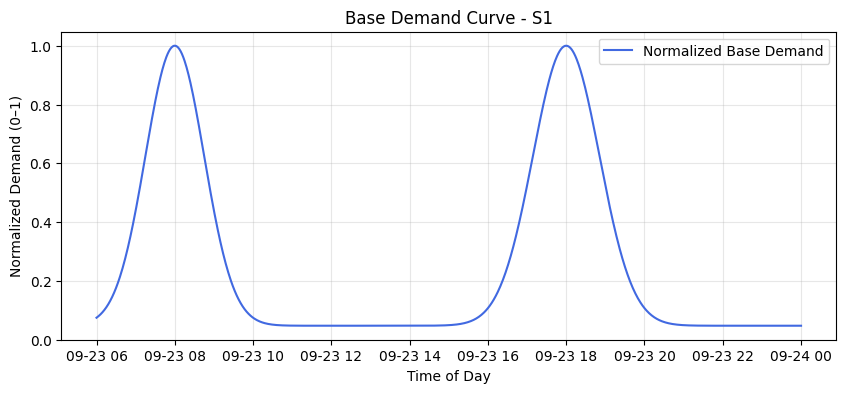

In [ ]:
 # 4. Plot Example
# ============================================================

example_station = "S1"
df_example = generate_base_day(example_station, config)

plt.figure(figsize=(10,4))
plt.plot(df_example["timestamp"], df_example["base_demand_norm"], label="Normalized Base Demand", color="royalblue")
plt.title(f"Base Demand Curve - {example_station}")
plt.xlabel("Time of Day")
plt.ylabel("Normalized Demand (0–1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:

# 5. Generate for All Stations
# ============================================================

all_df = []
for st in stations:
    sid = st["station_id"]
    df = generate_base_day(sid, config)
    all_df.append(df)

base_df = pd.concat(all_df, ignore_index=True)

print(f"Generated base demand for {len(stations)} stations, {len(base_df)} total records ✅")

Generated base demand for 6 stations, 6486 total records ✅
